# Analysis of sequencing data from competition between wildtype virus and mutant virus

Orr Ashenberg, 24 August 2016

To run the commands in this notebook, please first install <a href='https://github.com/jbloom/mapmuts'>```mapmuts```</a>  and <a href='https://github.com/jbloomlab/dms_tools'>```dms_tools```</a>, and then verify that they can be run in the directory in which you placed this ipython notebook.


Here, we take sequencing data from each viral competition experiment and calculate the frequency of the wildtype versus the mutant virus. We tested amino-acid mutations and synonymous codon mutations. There are 4 experimental conditions for the amino-acid mutation and 4 for the synonymous mutation (add syn to the experimental condition name below): 
 - CMU: 10 hrs post-infection, collect cellular RNA from MDCK-SIAT1 cells 
 - CXU: 10 hrs post-infection, collect cellular RNA from MDCK-SIAT1-MxA cells  
 - CMS: 54 hrs post-infection, collect cellular RNA from MDCK-SIAT1 cells  
 - CXS: 54 hrs post-infection, collect cellular RNA from MDCK-SIAT1-MxA cells  
 
 ---

## Table of contents

### Load required modules and raw data
<a href='#prelim'>Preliminary set-up and load required modules</a>

<a href='#download_SRA'>Download sequencing data from the SRA</a>

### Calculate mutant and wildtype codon counts at NP site 51
<a href='#align_reads'>Align paired-end reads to NP and count mutations</a>

<a href='#frequency'>Calculate mutation frequency at NP site 51</a>

### Plot competition-experiment results
<a href='#plot'>Plot relative NP mutation frequencies over time</a>

---

## Load required modules and raw data

<a id='prelim'></a>
**Preliminary set-up and load required modules:**

In [1]:
import os
basedir = os.getcwd()
if not os.path.isdir('notebook_figures'):
    !mkdir notebook_figures
if not os.path.isdir('FASTQ_files'):
    !mkdir FASTQ_files
figdir = '%s/notebook_figures' % basedir

import matplotlib
print "Using matplotlib version %s" % matplotlib.__version__
matplotlib.use("Pdf")
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import Bio.SeqIO
from operator import itemgetter
import os
import subprocess
import math
import glob
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format # Limit output to 3 decimal places.
import dms_tools
import dms_tools.file_io
import dms_tools.utils
from runscriptfunctions import * # functions to facilitate running parallel jobs on the Fred Hutch scientific computing cluster using `slurm`

Using matplotlib version 1.5.0


Specifications for running scripts. Nothing here needs to be changed by the user.

In [2]:
# Where FASTQ files from SRA will be downloaded
FASTQdir = '%s/FASTQ_files' % basedir

# Where to save graphs of mutation frequencies
outdir = '%s/analysis/mutant_frequency' % basedir

# Specify the biological replicates and library amplicons that were sequenced.
replicates = ['1', '2']

# Specify reference sequence to map reads to, numbering must follow what is specified by alignspecs
refseq = '%s/input/Aichi68-NP_amplicon.fa' % basedir
refseq = [seq for seq in Bio.SeqIO.parse(open(refseq), 'fasta')]
refseq = str(refseq[0].seq).upper()
refseq = refseq[61:1558]   # get full Aichi/68-NP coding sequence from start to stop codon

# Specify the experiments that test viral growth early or late in infection, and in MDCK-SIAT1 or MDCK-SIAT1-MxA cells.
# The experiments are further specified by whether they are competitions between nonsynonymous or synonynous mutants.
experiments_nonsyn = ['CMU', 'CXU', 'CMS', 'CXS']
experiments_syn = ['CMUsyn', 'CXUsyn', 'CMSsyn', 'CXSsyn']
experiments = experiments_nonsyn + experiments_syn

# Specify which NP mutations were tested in the viral competition experiment.
# List of tuples (NP site, MxA-sensitive aa, MxA-resistant aa, Bloom lab plasmid number) or (NP site, wt codon, synonymous codon, Bloom lab plasmid number)
tested_muts = [('51', 'N', 'D', 1409), ('51', 'GAT', 'GAC', 1500)] 

# Specify R1 and R2 read lengths and gene range of each NP amplicon, for aligning reads to amplicons. 
# The alignspecs are split into whether they are used for nonsynonymous, amino-acid mutations, or for synonymous, codon mutations.
alignspecs_nonsyn = [(113, 186, 1, 1, 1409)]
alignspecs_syn = [(113, 186, 1, 1, 1500)]

# List of amplicons using Bloom lab plasmid numbering
# The amplicons are split into whether they cover nonsynonymous amino-acid mutations, or synonymous codon mutations
amplicons_nonsyn = [amplicon for (a, b, c, d, amplicon) in alignspecs_nonsyn]   
amplicons_syn = [amplicon for (a, b, c, d, amplicon) in alignspecs_syn]

# Link Bloom lab plasmid amplicon numbering to Aichi/68 NP site numbering
amplicon_to_site = dict([ (amplicon, site) for (site, y, z, amplicon) in tested_muts])   

# Specify quality parameters (Q score thresholds) for deciding whether to use a given R1 and R2 read pair, and for how many nt mutations to allow while aligning amplicons
minq = 15
maxlowqfrac = 0.075
maxmuts = 2 

# Specify whether FASTQ sequence files are gzipped 
gzipped = False

<a id='download_SRA'></a>
**Download sequencing data from the SRA:**

In [3]:
%%capture
samples = {'SRR4048747':'CMU-1',
           'SRR4048748':'CXU-1',
           'SRR4048749':'CMS-1',
           'SRR4048750':'CXS-1',
           'SRR4048751':'CMUsyn-1',
           'SRR4048752':'CXUsyn-1',
           'SRR4048753':'CMSsyn-1',
           'SRR4048754':'CXSsyn-1',
           'SRR4048755':'CMU-2',
           'SRR4048756':'CXU-2',
           'SRR4048757':'CMS-2',
           'SRR4048758':'CXS-2',
           'SRR4048759':'CMUsyn-2',
           'SRR4048760':'CXUsyn-2',
           'SRR4048761':'CMSsyn-2',
           'SRR4048762':'CXSsyn-2'}

for (accession, samplename) in samples.items():
    print "Downloading and converting file format for sample %s, which corresponds to accession %s." % (samplename, accession)
    !cd FASTQ_files; wget --no-clobber 'ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR404/'$accession'/'$accession'.sra'
    !mv "FASTQ_files/"$accession".sra" "FASTQ_files/"$samplename".sra"
    !fastq-dump -O FASTQ_files/ --split-files "FASTQ_files/"$samplename".sra"

## Calculate mutant and wildtype codon counts at NP site 51

<a id='align_reads'></a>
**Align paired-end reads to NP and count mutations**

Below, we use functions from ```dms_tools``` to align paired-end reads to an amplicon that covers NP site 51.

First, we read in the names of read pair FASTQ files for each experiment. Each experimental condition has an R1 read file and an R2 read file.

In [4]:
# Store (r1file, r2file) in dictionary keyed by (replicate, experiment) ie (1, CMU)
fastqfiles = {}
for replicate in replicates:
    if not os.path.isdir('%s/replicate-%s' % (basedir, replicate)):
        os.mkdir('%s/replicate-%s' % (basedir, replicate))  
    for experiment in experiments:
        if not os.path.isdir('%s/replicate-%s/%s' % (basedir, replicate, experiment)):
            os.mkdir('%s/replicate-%s/%s' % (basedir, replicate, experiment))
        r1file = '%s/%s-%s_1.fastq' % (FASTQdir, experiment, replicate)
        r2file = '%s/%s-%s_2.fastq' % (FASTQdir, experiment, replicate)
        fastqfiles[(replicate, experiment)] = (r1file, r2file)     

Next we iterate through R1, R2 read pairs for each experiment and check quality of reads. Read pairs are discarded if any read has above a certain fraction of nucleotides with low Q score.

In [5]:
# Keep count of how many reads fall into each of the below categories
readcategories = ['total read pairs', 'read pairs that fail Illumina filter', 'low quality read pairs']

# Dictionary keyed by 'replicate experiment' ie (1 CMU), values are 2-tuple of paired R1 and R2 reads that pass quality filters
readpairs = {}

for replicate in replicates:
    for experiment in experiments: 
        readpairs['%s %s' % (replicate, experiment)] = []     
        
        # Dictionary keeping count of what category each read pair falls into 
        n = dict([(category, 0) for category in readcategories])

        (r1file, r2file) = fastqfiles[(replicate, experiment)]
        print r1file, r2file
        
        for read_tup in dms_tools.file_io.IteratePairedFASTQ([r1file], [r2file], gzipped, applyfilter=True):
            n['total read pairs'] += 1

            if read_tup:   # Read pair passed Illumina chastity filter
                (name, r1, r2, q1, q2) = read_tup
                (r1, r2, q1, q2) = dms_tools.utils.TrimReads(r1, r2, q1, q2, 75, 75)
                qcheckedreads = dms_tools.utils.CheckReadQuality(r1, r2, q1, q2, minq, maxlowqfrac, barcodelength=0)
                if qcheckedreads: # Read pair does not have a high fraction of ambiguous N nucleotides
                    (r1, r2) = qcheckedreads
                    readpairs['%s %s' % (replicate, experiment)].append((r1, r2))
                else:
                    n['low quality read pairs'] += 1
            else:
                n['read pairs that fail Illumina filter'] += 1
            if n['total read pairs'] % 1e5 == 0:
                print 'Reads parsed in %s %s so far: %d' % (replicate, experiment, n['total read pairs'])

/fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CMU-1_1.fastq /fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CMU-1_2.fastq
Reads parsed in 1 CMU so far: 100000
/fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CXU-1_1.fastq /fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CXU-1_2.fastq
Reads parsed in 1 CXU so far: 100000
/fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CMS-1_1.fastq /fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CMS-1_2.fastq
Reads parsed in 1 CMS so far: 100000
/fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CXS-1_1.fastq /fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CXS-1_2.fastq
Reads parsed in 1 CXS so far: 100000
/fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CMUsyn-1_1.fastq /fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CMUsyn-1_2.fastq
/fh/fast/bloom_j/grp/oashenbe/2016_NP_MxA_paper/FASTQ_files/CXUsyn-1_1.fastq /fh/fast/bloom_j/grp/oashenbe

Below, for each read pair in each experiment, try to align reads to one of the possible NP amplicons. Each NP amplicon is the product of a 1st and 2nd round PCR reaction centered around the mutation site of interest. The reactions add the Illumina adapters and experimental barcodes. A different alignspecs for aligning reads to an amplicon is used depending on whether the experiment is testing a nonysynonymous amino-acid mutation or a synonymous codon mutation. The counts for each experiment and mutation site combination are written to codon counts and amino-acid counts files.

In [6]:
# Iterate over all read pairs from each experiment, and align the reads to an amplicon region of the NP reference sequence.
# If the read pair aligns, update the mutation counts.
for replicate in replicates:
    for experiment in experiments:         
        # Choose alignspecs and amplicons based on whether this competition experiment is testing a nonsynonymous amino-acid mutation or synonymous codon mutation.
        if experiment in experiments_syn:
            alignspecs = alignspecs_syn
            amplicons = amplicons_syn
        else:
            alignspecs = alignspecs_nonsyn
            amplicons = amplicons_nonsyn
            
        # Initialize codon count dictionary for each amplicon to which the reads may be aligned
        # Key is amplicon and value is codon count dictionary that holds mutation counts in format for dms_tools.file_io.WriteDMSCounts
        counts = {}
        for amplicon in amplicons:
            counts[amplicon] = {}
            for r in range(1, len(refseq) // 3 + 1):
                counts[amplicon][str(r)] = dict([('WT', refseq[3 * r - 3 : 3 * r])] + [(codon, 0) for codon in dms_tools.codons])

        # For each read pair, try to align reads to amplicon iterating over the different amplicons specified by alignspecs
        numalign = 0
        for (r1, r2) in readpairs['%s %s' % (replicate, experiment)]:
            for (refseqstart, refseqend, r1start, r2start, amplicon) in alignspecs:
                maxN = int(maxlowqfrac * min(refseqend - refseqstart + 1, len(r1) + len(r2) - r1start - r2start + 2))
                if r1start >= len(r1) or r2start >= len(r2):
                    aligned = False # reads too short to align
                else:
                    aligned = dms_tools.utils.AlignSubamplicon(refseq, r1[r1start - 1 : ], r2[r2start - 1 : ], refseqstart, refseqend, maxmuts, 
                                                               maxN, 'codon', counts[amplicon], use_cutils=True)
                if aligned:
                    numalign += 1
                    break   # found the amplicon to which these reads align
        
        # Write the codon and amino acid counts for this experimental condition and set of amplicons (experiment, replicate, amplicon)
        countsdir = '%s/replicate-%s/%s' % (basedir, replicate, experiment)
        if not os.path.isdir(countsdir):
            os.mkdir(countsdir)
        for amplicon in amplicons:
            codoncountsfile = '%s/%s_%s_%s_codoncounts.txt' % (countsdir, replicate, experiment, amplicon)
            aacountsfile = '%s/%s_%s_%s_aacounts.txt' % (countsdir, replicate, experiment, amplicon)
            dms_tools.file_io.WriteDMSCounts(codoncountsfile, counts[amplicon])
            
            # Translate codon counts to amino-acid counts and write to file
            aacounts = dms_tools.file_io.ReadDMSCounts(codoncountsfile, 'codon', translate_codon_to_aa=True)
            dms_tools.file_io.WriteDMSCounts(aacountsfile, aacounts)

<a id='frequency'></a>
**Calculate mutation frequency at site 51**

The function below calculates amino acid or codon frequencies at a specified site

In [7]:
def CharacterFrequencyAtSite(counts, site, chartype):
    '''This function takes a dictionary of amino-acid or codon counts and calculates the frequency
    of each amino acid or codon at a specified site.
    
    *counts* : Dictionary of amino-acid or codon counts for each site using the format in `dms_tools.file_io.ReadDMSCounts`
    *site* : String giving the site at which to calculate amino-acid or codon frequencies of each amino acid or codon
    *chartype* is the type of character. Valid values are the following strings:
        - *codon* : DNA codons, those listed in the *codons* variable in `dms_tools.file_io'
        - *aminoacids_nostop* : amino acids, not including stop codons.
        - *aminoacids_withstop* : amino acids, including stop codons (``*``).
    *freqs* : Dictionary where each key is an amino acid or codon and the value is the corresponding
    amino-acid or codon frequency at that **site**
    '''
    if chartype.upper() == 'CODON':
        characters = dms_tools.codons
    elif chartype.upper() == 'AMINOACIDS_NOSTOP':
        characters = dms_tools.aminoacids_nostop
    elif chartype.upper() == 'AMINOACIDS_WITHSTOP':
        characters = dms_tools.aminoacids_withstop
    else:
        raise ValueError("Invalid chartype of %s" % chartype)
    if site not in counts:
        raise ValueError('Specified site %s not found in counts dictionary' % site)
                         
    totalcounts = sum([counts[site][char] for char in characters])
    if totalcounts:
        freqs = dict( [(char, float(counts[site][char]) / totalcounts) for char in characters] )
    else:
        print 'There are no counts at site %s' % site,
        freqs = dict( [(char, 0) for char in characters] )
    return freqs

Next we read in the codon counts and amino-acid counts at site 51 for each competition experiment and calculate their mutation frequencies. 

In [8]:
# Dictionaries storing amino-acid or codon frequencies. The key is 'replicate, experiment, site' ie (1, CMU, 51) and the value is
# a dictionary keyed by amino-acid or codon and the value is the corresponding frequency.
aafreqs = {}
codonfreqs = {}

# Read in amino-acid counts and codon counts, and calculate their frequencies at the sites tested in the competition experiment
for replicate in replicates:
    for experiment in experiments: 
        countsdir = '%s/replicate-%s/%s' % (basedir, replicate, experiment)
        # Choose amplicons based on whether this competition experiment is testing a nonsynonymous (amino-acid mutation) or synonymous codon mutation
        if experiment in experiments_syn:
            amplicons = amplicons_syn
        else:
            amplicons = amplicons_nonsyn
            
        for amplicon in amplicons:
            site = amplicon_to_site[amplicon]        # NP site in competition experiment

            aacountsfile = '%s/%s_%s_%s_aacounts.txt' % (countsdir, replicate, experiment, amplicon)
            aacounts = dms_tools.file_io.ReadDMSCounts(aacountsfile, 'aminoacids_withstop')
            aafreqs['%s %s %s' % (replicate, experiment, site)] = CharacterFrequencyAtSite(aacounts, site, 'aminoacids_withstop')
            
            codoncountsfile = '%s/%s_%s_%s_codoncounts.txt' % (countsdir, replicate, experiment, amplicon)
            codoncounts = dms_tools.file_io.ReadDMSCounts(codoncountsfile, 'codon')
            codonfreqs['%s %s %s' % (replicate, experiment, site)] = CharacterFrequencyAtSite(codoncounts, site, 'codon')

Next we print out amino-acid or codon mutation frequencies for the mutations tested in the competition experiment. We also quantify how each mutation was enriched (MxA resistant amino acid relative to MxA sensitive amino acid, or wildtype codon relative to synonymous codon). This enrichment, or relative mutation frequency, gets plotted at the end of the notebook.

In [9]:
columns = ['site', 'replicate', 'experiment', 'sens_freq', 'res_freq']
freq = pd.DataFrame(columns=columns)

for replicate in replicates:
    for (site, char1, char2, amplicon) in tested_muts:        
        # If this tested mutation is an amino-acid mutation
        if amplicon in amplicons_nonsyn:      
            (sensitive, resistant) = (char1, char2)
            for experiment in experiments_nonsyn:
                expkey = '%s %s %s' % (replicate, experiment, site)
                freq = freq.append(pd.DataFrame([[site, replicate, experiment, aafreqs[expkey][sensitive], aafreqs[expkey][resistant]]], columns=columns))

        # If this tested mutation is a synonymous mutation
        elif amplicon in amplicons_syn:
            (wt, syn) = (char1, char2)
            for experiment in experiments_syn:
                expkey = '%s %s %s' % (replicate, experiment, site)
                freq = freq.append(pd.DataFrame([[site, replicate, experiment, codonfreqs[expkey][syn], codonfreqs[expkey][wt]]], columns=columns))
        else:
            raise ValueError('Amplicon %s not found' % amplicon)
            
# Use mutation frequencies to calculate how each mutation was enriched
freq['enrich'] = freq['res_freq']/freq['sens_freq']   
freq

,site,replicate,experiment,sens_freq,res_freq,enrich
0,51,1,CMU,0.663,0.335,0.506
0,51,1,CXU,0.087,0.912,10.441
0,51,1,CMS,0.550,0.450,0.817
0,51,1,CXS,0.001,0.999,"1,007.000"
0,51,1,CMUsyn,0.466,0.533,1.142
0,51,1,CXUsyn,0.460,0.540,1.174
0,51,1,CMSsyn,0.412,0.588,1.428
0,51,1,CXSsyn,0.344,0.656,1.909
0,51,2,CMU,0.749,0.251,0.335
0,51,2,CXU,0.149,0.851,5.702


## Plot competition-experiment results

<a id='plot'></a>
**Plot relative NP mutation frequencies over time**

/home/oashenbe/.local/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


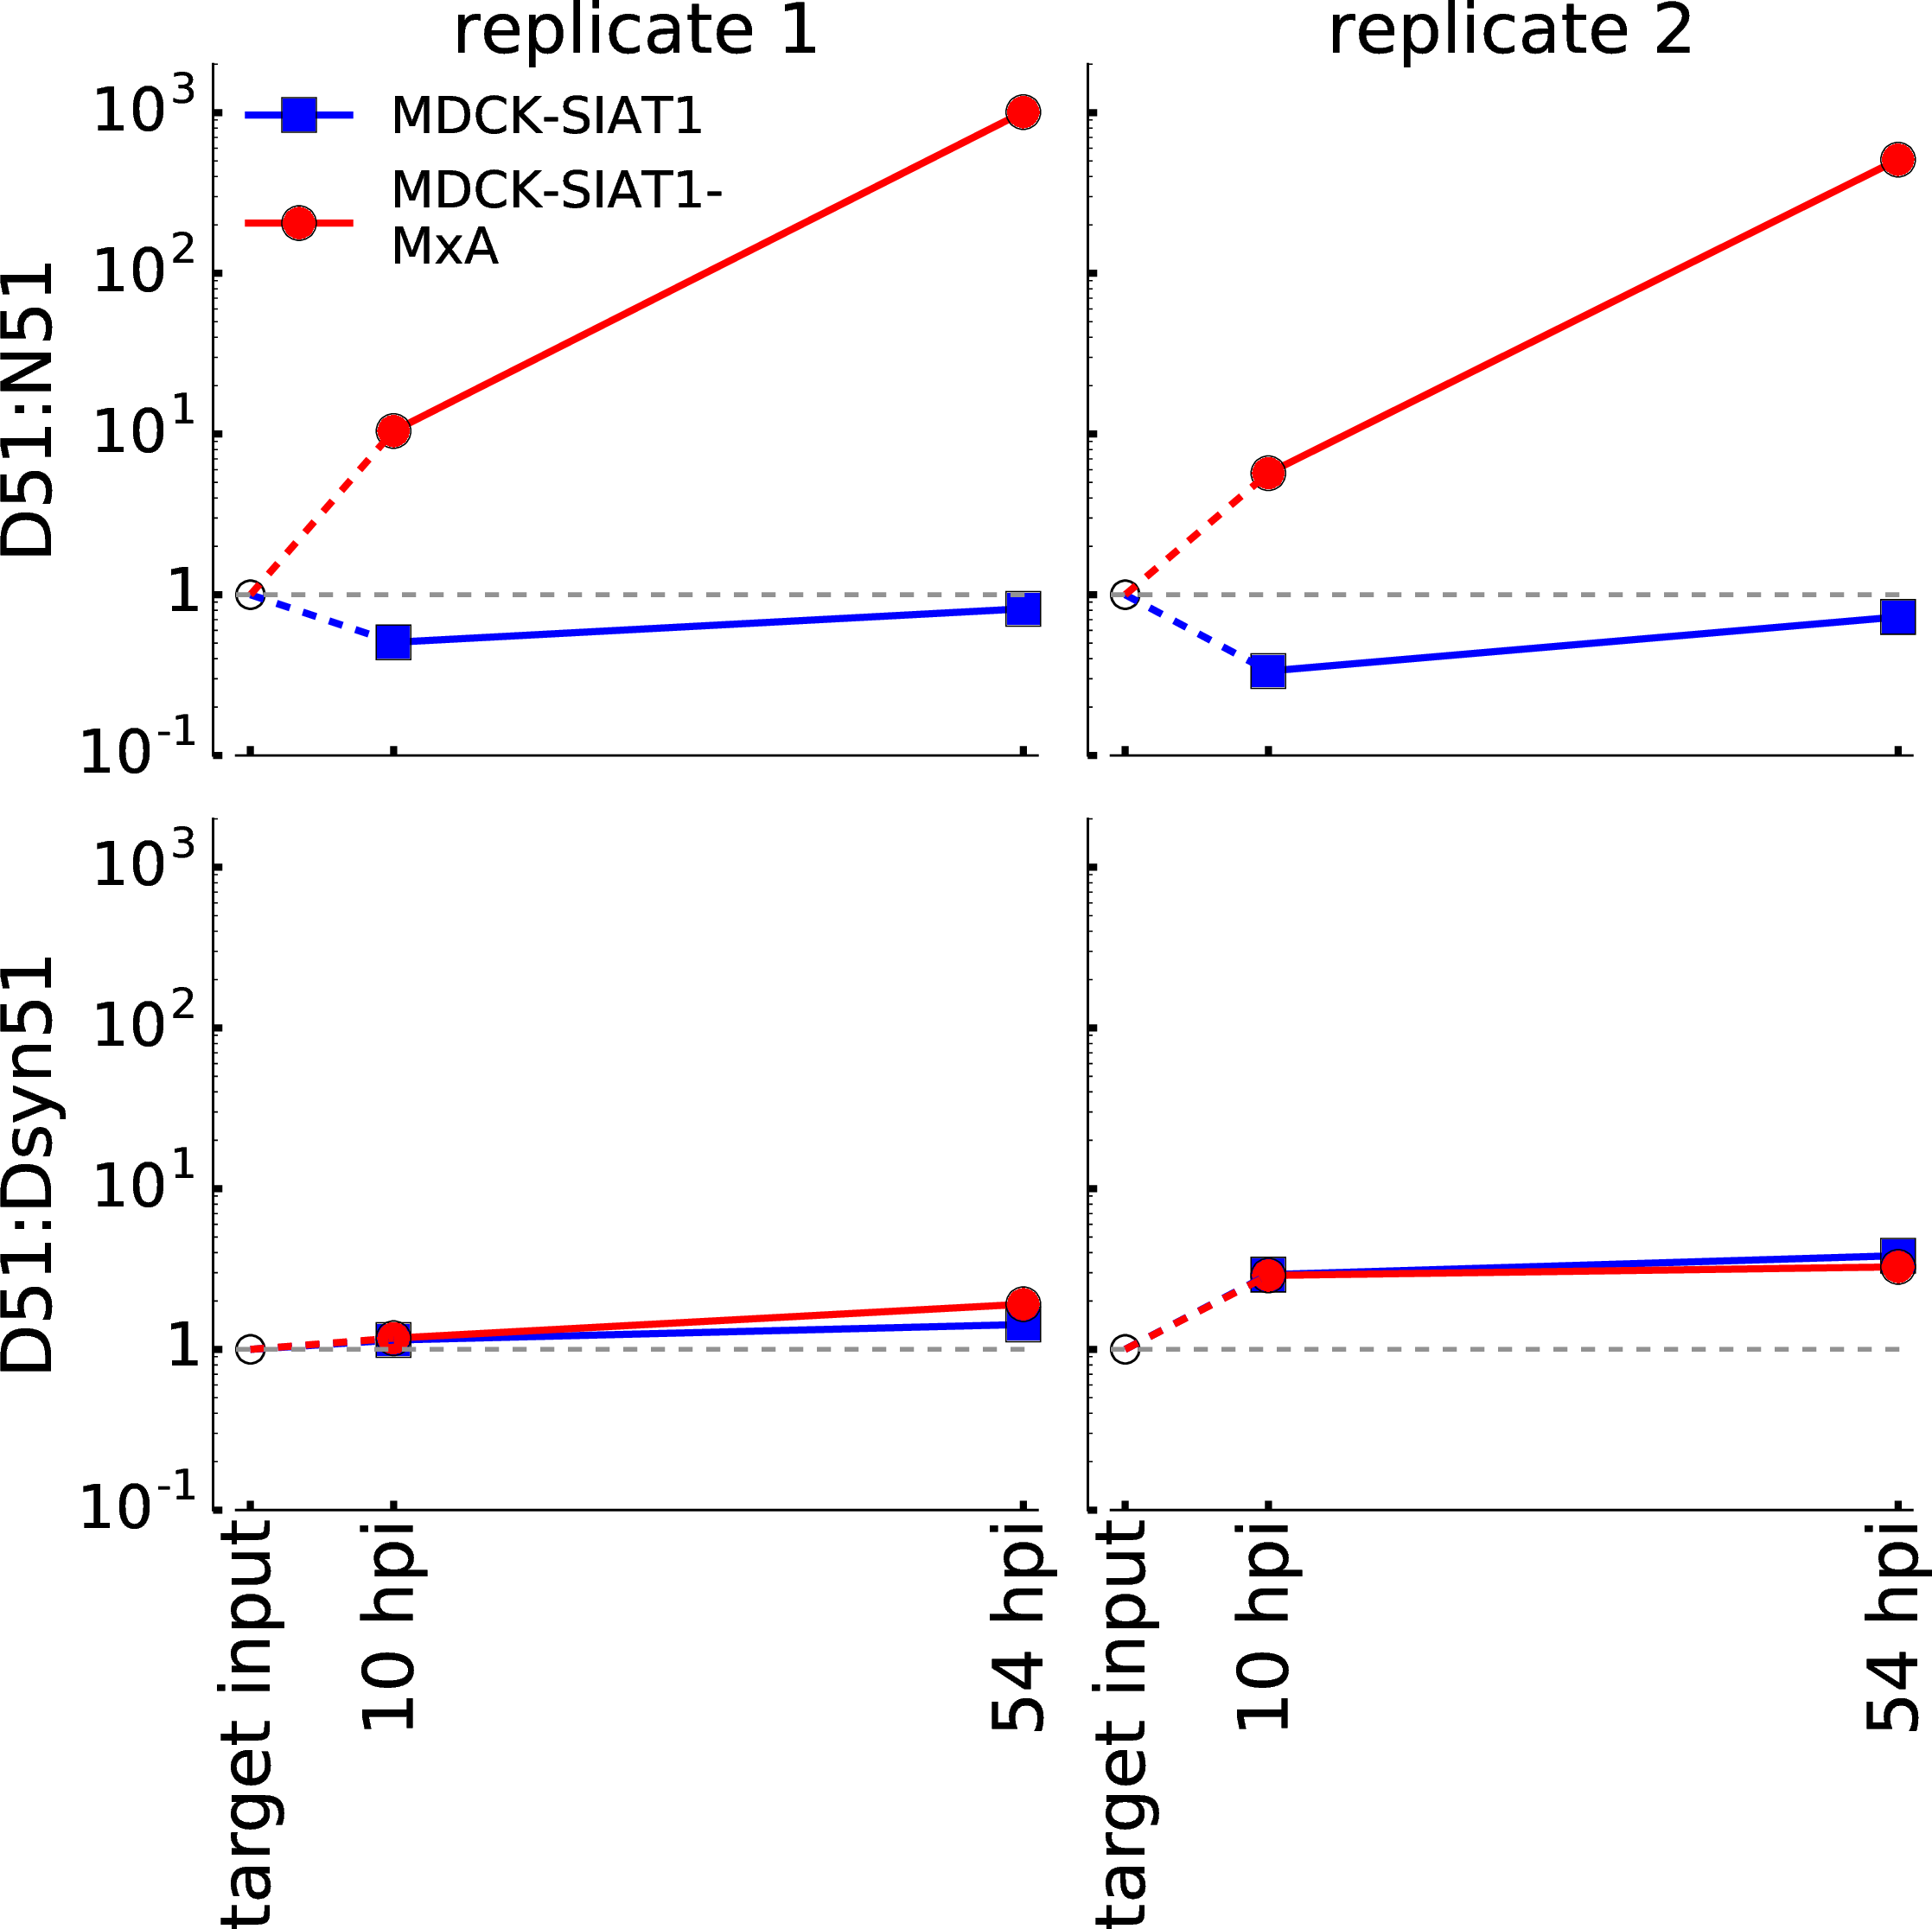

In [10]:
plotfile = '%s/competition.pdf' % figdir
plt.close('all') 
plt.rc('font', family='sans-serif')
site = '51'
xlabels = ['-MxA', '+MxA', '-MxA', '+MxA']
ylabel = 'Frequency'
times = [0, 10, 54]     # hours post-infection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Plot amino-acid or codon frequency for a given site depending on mutation type
# D51N
for replicate, ax in zip(replicates, (axes[0][0], axes[0][1])):
    plotfreq = dict([(experiment, float(freq[(freq.site==site) & (freq.replicate==replicate) & (freq.experiment==experiment)]['enrich'])) for experiment in experiments_nonsyn])

    # points and lines to connect for 10, 54 hrs post infection
    ax.plot(times[1:], [plotfreq['CMU'], plotfreq['CMS']], 'b', linewidth=3, marker='s', markersize=15, clip_on=False)    # MDCK-SIAT1
    ax.plot(times[1:], [plotfreq['CXU'], plotfreq['CXS']], 'r', linewidth=3, marker='o', markersize=15, clip_on=False)    # MDCK-SIAT1-MxA

    # points and dashed lines to connect to 0 hrs post infection (target input)
    ax.scatter(times[0], 1, facecolors='none', edgecolors='k', s=150, clip_on=False)
    ax.plot(times[:2], [1, plotfreq['CMU']], 'b--', linewidth=3)
    ax.plot(times[:2], [1, plotfreq['CXU']], 'r--', linewidth=3)

# D51Dsyn
for replicate, ax in zip(replicates, (axes[1][0], axes[1][1])):
    plotfreq = dict([(experiment, float(freq[(freq.site==site) & (freq.replicate==replicate) & (freq.experiment==experiment)]['enrich'])) for experiment in experiments_syn]) 

    # points and lines to connect for 10, 54 hrs post infection
    ax.plot(times[1:], [plotfreq['CMUsyn'], plotfreq['CMSsyn']], 'b', linewidth=3, marker='s', markersize=15, clip_on=False)    # MDCK-SIAT1
    ax.plot(times[1:], [plotfreq['CXUsyn'], plotfreq['CXSsyn']], 'r', linewidth=3, marker='o', markersize=15, clip_on=False)    # MDCK-SIAT1-MxA

    # points and dashed lines to connect to 0 hrs post infection (target input)
    ax.scatter(times[0], 1, facecolors='none', edgecolors='k', s=150, clip_on=False)
    ax.plot(times[:2], [1, plotfreq['CMUsyn']], 'b--', linewidth=3)
    ax.plot(times[:2], [1, plotfreq['CXUsyn']], 'r--', linewidth=3)

# Axis properties
spineOffset = {'left': 10, 'bottom': 0}    
for ax in axes.flatten():
    ax.axhline(y=1, linewidth=2, color='gray', linestyle='--')

    [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ] 
    ax.xaxis.set(ticks_position = 'bottom')
    ax.yaxis.set(ticks_position = 'left')

    ax.set_xlim([times[0]-1, times[2]+1])
    ax.set_xticks(times)
    ax.xaxis.set_tick_params(width=3)
    ax.set_xticklabels([])
    
    ax.set_yscale('log')
    ax.set_ylim([1e-1, 2e3])
    ax.yaxis.set_tick_params(labelsize=20, width=3)
    ax.set_yticklabels([])

axes[0,0].set_title('replicate 1', fontsize=30)
axes[0,1].set_title('replicate 2', fontsize=30)

axes[1,0].set_xticklabels(['target input', '10 hpi', '54 hpi'], fontsize=30, rotation='vertical')
axes[1,1].set_xticklabels(['target input', '10 hpi', '54 hpi'], fontsize=30, rotation='vertical')

axes[0,0].set_ylabel('D51:N51', fontsize=30)
axes[1, 0].set_ylabel('D51:Dsyn51', fontsize=30)
axes[0,0].legend(['MDCK-SIAT1', 'MDCK-SIAT1-\nMxA'], bbox_to_anchor=(.4,.96), bbox_transform=plt.gcf().transFigure, frameon=False, numpoints=1, fontsize=22)

ylabels = ['$\mathregular{10^{-1}}$', '$\mathregular{1}$', '$\mathregular{10^{1}}$', '$\mathregular{10^{2}}$', '$\mathregular{10^{3}}$']
axes[0,0].set_yticks([1e-1, 1, 1e1, 1e2, 1e3])
axes[1,0].set_yticks([1e-1, 1, 1e1, 1e2, 1e3])
axes[0,0].set_yticklabels(ylabels, fontsize=26)
axes[1,0].set_yticklabels(ylabels, fontsize=26)

plt.tight_layout()
plt.savefig(plotfile)
ShowPDFinline(plotfile, figdir, 700)